# Модель для прогнозирования клика (CTR) для рекламной платформы Advandex

## Описание исследования

В рамках данного исследования разрабатывается и калибруется модель машинного обучения для прогнозирования вероятности клика (Click-Through Rate, CTR) на рекламные объявления на платформе Advandex. Проект направлен на создание точного и достоверного инструмента, предсказания которого будут использоваться для оптимизации ставок в системах реального времени (RTB-аукционах). Это позволит платформе принимать финансово эффективные решения, балансируя между выигрышем аукционов по справедливой цене и минимизацией упущенной выгоды.

Актуальность исследования обусловлена прямой зависимостью бизнес-модели платформы от достоверности прогнозов. Некорректно калиброванные вероятности приводят к прямым финансовым потерям: завышение прогнозов ведет к переплате за показы и сжиганию бюджета, а занижение — к проигрышу аукционов и упущенному доходу. Точная модель CTR является ключевым конкурентным преимуществом на рынке цифровой рекламы.

## Цель исследования

Разработать хорошо калиброванную модель бинарной классификации, способную не только точно ранжировать объявления по вероятности клика, но и выдавать предсказанные вероятности, максимально соответствующие реальной частоте наступления событий. Это обеспечит финансовую устойчивость механизма аукционов и повысит доверие рекламодателей к платформе.

## Суть исследования

Исследование заключается в анализе взаимосвязей между характеристиками пользователя, объявления, контекста показа и фактом совершения клика. Основная задача — построить модель, которая не только выявляет паттерны, ведущие к клику, но и обеспечивает калибровку своих прогнозов, чтобы численные значения вероятности могли напрямую использоваться для расчета ставок. Исследование носит прикладной характер с прямым экономическим эффектом.

## Постановка задачи машинного обучения

### Вид задачи
Бинарная классификация — задача предсказания вероятности принадлежности события к одному из двух классов: «клик не произойдет» (0) или «клик произойдет» (1).

### Тип задачи
Обучение с учителем — на основе размеченных исторических данных о показах объявлений и соответствующих им фактах кликов.

### Целевая переменная
click — бинарный признак:

0: показ рекламного объявления не привел к клику.

1: пользователь кликнул на рекламное объявление.

## Критерии успешности проекта
Модель должна обеспечить баланс между:

1. Высоким качеством ранжирования — эффективно отделять объявления с высоким потенциалом кликабельности от низкого.

2. Отличной калибровкой — предсказанные вероятности должны достоверно отражать реальную частоту кликов (например, если модель предсказывает 20%, то в этой группе объявлений клик должен происходить примерно в 20% случаев).

3. Стабильностью — устойчивость метрик на новых данных (разница в ключевых метриках между выборками train/valid/test должна быть минимальной).

## Метрики качества

- PR-AUC (Precision-Recall Area Under Curve) — основная метрика для оценки качества классификации. Наиболее информативна при сильном дисбалансе классов (клики — редкое событие), так как фокусируется на корректном предсказании именно целевого класса (кликов), игнорируя корректные предсказания многочисленного класса «не кликов».


- Log Loss (Логистическая потеря) — ключевая метрика для оценки точности предсказанных вероятностей. Сильно штрафует модель как за ошибки классификации, так и за излишнюю «уверенность» в неверном прогнозе. Минимизация Log Loss напрямую способствует улучшению калибровки.


- Оценка Бриера (Brier Score) — комбинированная метрика, измеряющая и точность (calibration), и разрешающую способность (resolution) прогнозов. Идеально откалиброванная модель имеет Brier Score, близкий к 0. Это прямая интегральная оценка надежности вероятностных прогнозов.

## 1. Подготовка среды и загрузка данных

#### 1.1 Подготовьте библиотеки
- Создайте файл `requirements.txt` с фиксированными версиями всех пакетов.
- Импортируйте все необходимые библиотеки.
- Настройте параметры отображения графиков и датафреймов.

#### 1.2 Зафиксируйте константу для воспроизводимости
- Установите константу `RANDOM_SEED`.
- Применяйте её ко всем алгоритмам, которые её поддерживают.

#### 1.3 Загрузите данные
- Прочитайте CSV-файл с данными. Путь к файлу: `'/datasets/ds_s16_ad_click_dataset.csv'`
- Выведите размер датасета, первые несколько строк и информацию о типах столбцов.
- Проверьте успешность загрузки данных.

In [1]:
!pip install --upgrade scikit-learn -q
!pip install phik -q


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import numpy as np
import pandas as pd
import phik
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, SGDRegressor, LinearRegression
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, 
    log_loss, make_scorer, average_precision_score, brier_score_loss, accuracy_score, 
    precision_score, recall_score
)
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFE
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.frozen import FrozenEstimator
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import expit

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
plt.rcParams["figure.figsize"] = (12,6)

In [6]:
df = pd.read_csv('ds_s16_ad_click_dataset.csv', sep=',', decimal='.')

In [7]:
with pd.option_context('display.max_columns', None): 
    display(df.head())

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,ml_feature_1,ml_feature_2,ml_feature_3,ml_feature_4,ml_feature_5,ml_feature_6,ml_feature_7,ml_feature_8,ml_feature_9,ml_feature_10
0,1.005263e+19,1,14102100,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,488a9a3e,31025cda,1,0,17614,320,50,1993,2,1063,-1,33,-0.996823,A,0.666588,0,0.817292,0.993275,Z,-0.619959,0.433666,0.274038
1,1.010597e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,75bb1b58,2ee63ff8,1,0,15701,320,50,1722,0,35,-1,79,-0.391309,C,5.146789,1,-0.883865,-0.825722,X,0.576526,-0.318558,-0.132851
2,1.012048e+19,0,14102100,1005,0,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,285263b0,d780319b,1,0,17914,320,50,2043,2,39,100084,32,-2.112732,D,7.169348,0,-0.859440,-0.338365,Y,-0.440047,-0.345412,0.340487
3,1.021995e+18,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,39cfef32,d9b5648e,0f2161f8,a99f214a,18190986,f4fffcd0,1,0,21611,320,50,2480,3,297,100111,61,0.332707,A,-0.290708,1,0.062795,0.062934,Y,0.551982,0.733382,-0.198542
4,1.023455e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b66e5482,a0f5f879,1,0,15702,320,50,1722,0,35,100084,79,1.166623,A,6.319134,1,-0.675276,0.797144,X,0.640827,0.297955,-0.136909


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                50000 non-null  float64
 1   click             50000 non-null  int64  
 2   hour              50000 non-null  int64  
 3   C1                50000 non-null  int64  
 4   banner_pos        50000 non-null  int64  
 5   site_id           50000 non-null  object 
 6   site_domain       50000 non-null  object 
 7   site_category     50000 non-null  object 
 8   app_id            50000 non-null  object 
 9   app_domain        50000 non-null  object 
 10  app_category      50000 non-null  object 
 11  device_id         50000 non-null  object 
 12  device_ip         50000 non-null  object 
 13  device_model      50000 non-null  object 
 14  device_type       50000 non-null  int64  
 15  device_conn_type  50000 non-null  int64  
 16  C14               50000 non-null  int64 

## 2. Исследовательский анализ данных (EDA)

#### 2.1 Опишите базовую информацию о датасете
- Определите, сколько объектов и признаков содержится в данных.
- Выясните, какие типы данных представлены (числовые, категориальные).
- Дайте общее описание: укажите, что известно о пользователях и рекламе.

#### 2.2 Анализ целевой переменной
- Проанализируйте, как распределена целевая переменная.
- Определите, есть ли дисбаланс классов. Это важно для выбора метрик.
- Посчитайте долю рекламы, на которую кликнули, и долю рекламы, на которую не кликнули.

#### 2.3 Анализ признаков
- Определите, все ли признаки нужны для обучения модели. Есть ли среди них явно бесполезные?
- Опишите, какие признаки категориальные, а какие — числовые.
- Проведите первичный отбор: удалите ненужные признаки.

#### 2.4 Анализ пропущенных значений
- Проверьте долю пропусков в каждом признаке.
- Выберите корректную стратегию для заполнения пропусков — удаление, среднее, медиана, мода. Выбор обоснуйте.

#### 2.5 Анализ категориальных признаков
- Определите, сколько уникальных значений в каждом категориальном признаке.
- Укажите, какие признаки можно кодировать One-Hot Encoding, а какие требуют специальных методов из-за высокой кардинальности.

#### 2.6 Анализ выбросов и распределений
- Проверьте, есть ли явные выбросы в числовых признаках.
- Опишите, как распределены выбросы — нормально, асимметрично, каким-то другим образом.

#### 2.7 Корреляции
- Определите, какие признаки коррелируют с целевой переменной.
- Выявите сильно скоррелированные признаки, которые можно удалить, если такие есть.

#### 2.8 Выводы по EDA
- Кратко опишите ключевые находки.
- Выберите признаки, которые выглядят наиболее перспективными для модели. Выбор обоснуйте.
- Определите действия по предобработке данных, которые необходимо проделать.

In [9]:
df.shape

(50000, 34)

Столбцы датасета

- id — уникальный идентификатор записи о показе баннера;
- hour — час, в который был показан баннер, в формате YYMMDDHH.


- site_id — идентификатор веб-сайта, на котором был показан баннер;
- site_domain — домен веб-сайта;
- site_category — тематическая категория веб-сайта.


- app_id — идентификатор рекламируемого мобильного приложения;
- app_domain — домен рекламируемого приложения;
- app_category — категория рекламируемого приложения.


- device_id — идентификатор браузера или устройства;
- device_ip — IP-адрес устройства;
- device_model — модель устройства;
- device_type — тип устройства пользователя: например, смартфон, планшет, ПК;
- device_conn_type — тип сетевого соединения устройства: например, Wi-Fi, 3G, 4G.


- banner_pos — позиция баннера на веб-странице;
- C1 — анонимизированный признак, характеризующий контекст показа;
- C14 — C21 — группа анонимизированных признаков, описывающих параметры баннера, пользователя или аукциона.


- ml_feature_1, ml_feature_3 — ml_feature_6, ml_feature_8 — ml_feature_10 — числовые признаки, полученные в результате предварительной обработки и генерации новых признаков;
- ml_feature_2, ml_feature_7 — категориальные признаки, полученные в результате предварительной обработки и генерации новых признаков.

Целевая переменная:
- click — бинарный признак, указывающий, был ли совершён клик по баннеру. 1 — клик был, 0 — клика не было.

Заметим что про ml_feature_9 не было сказано, это числовой признак

In [10]:
df['click'].value_counts()

click
0    41397
1     8603
Name: count, dtype: int64

У целевого признака есть выраженный дисбаланс - 17% кликов относительно всех показов

---

In [11]:
df_copy = df.copy() # Для проверки преобразований

---

id — уникальный идентификатор записи о показе баннера, не несет информации при обучении, необходимо будет удалить

In [12]:
df_copy = df_copy.drop(columns=['id'])

---

In [13]:
df['hour'].describe()

count    5.000000e+04
mean     1.410256e+07
std      2.967892e+02
min      1.410210e+07
25%      1.410230e+07
50%      1.410260e+07
75%      1.410281e+07
max      1.410302e+07
Name: hour, dtype: float64

In [14]:
df['hour'].min()

np.int64(14102100)

In [15]:
df['hour'].max()

np.int64(14103023)

По минимальному и максимальному значению признака hour можно сделать вывод что данне собраны за 10 дней

Так же при обучении модели думаю будет важна информация о дне недели и времени показа, поэтому этот признак стоит преобразовать в два других - день недели и час, причем учитывая цикличность значений, значения, например, для часа 00 и 23 без синус-косинусного преобразования будут располагаться далеко для модели. Поэтому так же применим это преобразование

In [16]:
def make_weekday_hour_features(df):
    weekday = pd.to_datetime(df['hour'].astype(str), format='%y%m%d%H').dt.weekday
    hour_of_day = df['hour'] % 100
    
    df['hour_sin'] = np.sin(2 * np.pi * hour_of_day / 24)
    df['hour_cos'] = np.cos(2 * np.pi * hour_of_day / 24)

    df['weekday_sin'] = np.sin(2 * np.pi * weekday / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * weekday / 7)

In [17]:
make_weekday_hour_features(df_copy)
display(df_copy['hour_sin'].value_counts())
display(df_copy['weekday_cos'].value_counts())

hour_sin
 9.659258e-01    4887
 5.000000e-01    4288
-2.588190e-01    3013
 1.224647e-16    2822
 7.071068e-01    2818
-5.000000e-01    2698
-7.071068e-01    2536
 8.660254e-01    2535
-8.660254e-01    2520
-9.659258e-01    2488
 2.588190e-01    2481
 8.660254e-01    2378
 1.000000e+00    2200
-1.000000e+00    2168
 7.071068e-01    1653
-9.659258e-01    1598
-8.660254e-01    1366
-7.071068e-01    1235
 2.588190e-01    1183
 0.000000e+00    1094
-5.000000e-01    1082
-2.588190e-01     957
Name: count, dtype: int64

weekday_cos
 0.623490    11743
-0.222521    11256
-0.900969    10056
 0.623490     4710
-0.222521     4179
-0.900969     4077
 1.000000     3979
Name: count, dtype: int64

---

In [18]:
df['site_id'].value_counts()

site_id
85f751fd    18011
1fbe01fe     7968
e151e245     3234
d9750ee7     1262
5b08c53b     1120
            ...  
ce5ad4c4        1
c306b25a        1
49666f00        1
ba85e0e9        1
c0d83cac        1
Name: count, Length: 1160, dtype: int64

Слишком много уникальных значений, можно было бы выделить топ сайтов, агрегировать и использовать эту информацию, но в данном случае предлагаю отказаться от этого столбца, особенно учитывая наличие поля site_category

---

In [19]:
df['app_id'].value_counts()

app_id
ecad2386    31989
92f5800b     1954
e2fcccd2     1368
febd1138      904
9c13b419      876
            ...  
ea6346eb        1
54964296        1
1c52ac8f        1
a7bae86c        1
c5801e1d        1
Name: count, Length: 976, dtype: int64

По аналогии с site_id поле app_id так же планирую удалить, отчасти потому что в наличии есть app_category

---

In [20]:
df['site_domain'].value_counts()

site_domain
c4e18dd6    18645
f3845767     7968
7e091613     4088
7687a86e     1544
98572c79     1303
            ...  
64dd1c99        1
6aa01f64        1
cee5ef47        1
6648d6af        1
6a480beb        1
Name: count, Length: 1013, dtype: int64

In [21]:
df['app_domain'].value_counts()

app_domain
7801e8d9    33763
2347f47a     6473
ae637522     2341
5c5a694b     1368
82e27996      904
            ...  
57cf0548        1
5b3f66ff        1
63f57be0        1
fd0f197b        1
b408d42a        1
Name: count, Length: 67, dtype: int64

site_domain и app_domain - на мой взгляд не принесут пользы при обучении, так же кандидаты на удаление

---

In [22]:
df['site_category'].value_counts()

site_category
50e219e0    20457
f028772b    15777
28905ebd     9061
3e814130     3729
f66779e6      310
75fa27f6      197
335d28a8      166
76b2941d      126
c0dd3be3       59
72722551       31
dedf689d       27
70fb0e29       26
0569f928       14
8fd0aea4        9
a818d37a        7
e787de0e        2
bcf865d9        1
42a36e14        1
Name: count, dtype: int64

In [23]:
df['app_category'].value_counts()

app_category
07d7df22    32388
0f2161f8    11843
cef3e649     2123
8ded1f7a     1793
f95efa07     1375
d1327cf5      163
dc97ec06       82
09481d60       78
75d80bbe       50
4ce2e9fc       24
fc6fa53d       23
879c24eb       14
a3c42688       14
4681bb9d       11
0f9a328c        9
2281a340        3
8df2e842        2
a7fd01ec        1
18b1e0be        1
0bfbc358        1
79f0b860        1
7113d72a        1
Name: count, dtype: int64

Для site_category и app_category не так много уникальных значений, и по логике эти признаки могут влиять в значительной мере на вероятность клика, ведь она зависит от контекста приложения/сайта

Стоит обратить внимание на наличие редких категорий, которые необходимо группировать, т.к. модель все-равно не сможет на них обучиться

In [24]:
def make_site_category_grouped_feature(df):
    threshold = 100
    value_counts = df['site_category'].value_counts()

    rare_categories = value_counts[value_counts < threshold].index
    df['site_category_grouped'] = df['site_category'].apply(
        lambda x: 'OTHER' if x in rare_categories else x
    )

In [25]:
def make_app_category_grouped_feature(df):
    threshold = 100
    value_counts = df['app_category'].value_counts()

    rare_categories = value_counts[value_counts < threshold].index
    df['app_category_grouped'] = df['app_category'].apply(
        lambda x: 'OTHER' if x in rare_categories else x
    )

In [26]:
make_site_category_grouped_feature(df_copy)
make_app_category_grouped_feature(df_copy)
display(df_copy['site_category_grouped'].value_counts())
display(df_copy['app_category_grouped'].value_counts())

site_category_grouped
50e219e0    20457
f028772b    15777
28905ebd     9061
3e814130     3729
f66779e6      310
75fa27f6      197
OTHER         177
335d28a8      166
76b2941d      126
Name: count, dtype: int64

app_category_grouped
07d7df22    32388
0f2161f8    11843
cef3e649     2123
8ded1f7a     1793
f95efa07     1375
OTHER         315
d1327cf5      163
Name: count, dtype: int64

---

In [27]:
df['device_id'].value_counts()

device_id
a99f214a    41213
c357dbff       27
0f7c61dc       26
936e92fb       16
afeffc18       11
            ...  
98aa9cb6        1
ec4c5d2d        1
ccb5aa31        1
0eb76fe1        1
d533161f        1
Name: count, Length: 8580, dtype: int64

In [28]:
df['device_ip'].value_counts()

device_ip
6b9769f2    265
431b3174    169
d90a7774    119
2f323f36    112
930ec31d    109
           ... 
1a8e03a3      1
bce95508      1
3d752f16      1
1bc7d39a      1
18190986      1
Name: count, Length: 41455, dtype: int64

In [29]:
df['device_model'].value_counts()

device_model
8a4875bd    3007
d787e91b    1734
1f0bc64f    1711
76dc4769     963
be6db1d7     930
            ... 
22433db2       1
d870e4de       1
80c2a034       1
b9f04800       1
0f85dc35       1
Name: count, Length: 2521, dtype: int64

device_id, device_ip, device_model - большое количество категорий, а для device_id особенно странно видеть что почти из всех значений одно и тоже занимает более 80%

Думаю по логике вероятность клика по рекламе может и модет как-то зависеть от модели телефона, но учитывая наличие таких полей как device_type и device_conn_type - эти поля дадут информацию, а вышеперечисленный можно удалить, учитывая значительный дизбаланс классов для device_id

---

In [30]:
df['device_type'].value_counts()

device_type
1    46031
0     2790
4     1020
5      159
Name: count, dtype: int64

In [31]:
df['device_conn_type'].value_counts()

device_conn_type
0    43021
2     4163
3     2774
5       42
Name: count, dtype: int64

Тут значительно меньше категорий, думаю допустимо оставить эти признаки как есть (хотя и можно группировать device_conn_type)

---

In [32]:
df['banner_pos'].value_counts()

banner_pos
0    35883
1    14019
7       61
2       13
4       11
5        7
3        6
Name: count, dtype: int64

In [33]:
def make_banner_pos_grouped_feature(df):
    threshold = 100
    value_counts = df['banner_pos'].value_counts()

    rare_categories = value_counts[value_counts < threshold].index
    df['banner_pos_grouped'] = df['banner_pos'].apply(
        lambda x: 'RARE' if x in rare_categories else x
    )

make_banner_pos_grouped_feature(df_copy)
display(df_copy['banner_pos_grouped'].value_counts())

banner_pos_grouped
0       35883
1       14019
RARE       98
Name: count, dtype: int64

---

In [34]:
df['C1'].value_counts()

C1
1005    45835
1002     2790
1010     1179
1012      135
1007       38
1001       16
1008        7
Name: count, dtype: int64

In [35]:
def make_C1_grouped_feature(df):
    threshold = 150
    value_counts = df['C1'].value_counts()

    rare_categories = value_counts[value_counts < threshold].index
    df['C1_grouped'] = df['C1'].apply(
        lambda x: 'RARE' if x in rare_categories else x
    )

make_C1_grouped_feature(df_copy)
display(df_copy['C1_grouped'].value_counts())

C1_grouped
1005    45835
1002     2790
1010     1179
RARE      196
Name: count, dtype: int64

---

In [36]:
for i in range(14, 22):
    print(f'C{i}:')
    print(df[f'C{i}'].value_counts())
    print()

C14:
C14
4687     1200
21611    1083
21191     977
21189     936
19772     911
         ... 
23784       1
23836       1
23908       1
11993       1
23636       1
Name: count, Length: 1497, dtype: int64

C15:
C15
320     46787
300      2758
216       367
728        78
1024        5
768         3
480         1
120         1
Name: count, dtype: int64

C16:
C16
50      47287
250      2135
36        367
480       123
90         78
768         5
1024        3
320         1
20          1
Name: count, dtype: int64

C17:
C17
1722    5637
2424    1913
2227    1822
1800    1481
423     1200
        ... 
2635       1
2651       1
2702       1
2689       1
1426       1
Name: count, Length: 387, dtype: int64

C18:
C18
0    21074
3    16855
2     8769
1     3302
Name: count, dtype: int64

C19:
C19
35      14964
39      11013
167      3915
161      1950
47       1780
        ...  
1583        6
417         4
45          1
1195        1
683         1
Name: count, Length: 64, dtype: int64

C20:
C20
-1 

Попробуем сгруппировать признаки С14-С21 чтобы уменьшить количество категорий

In [37]:
def make_C14_C21_grouped_features(df):
    threshold = 100
    
    for i in range(14, 22):
        col_name = f'C{i}'
        value_counts = df[col_name].value_counts()
        
        rare_categories = value_counts[value_counts < threshold].index
        new_col_name = f'{col_name}_grouped'
        
        df[new_col_name] = df[col_name].apply(
            lambda x: 'RARE' if x in rare_categories else x
        )
    
    return df

In [38]:
make_C14_C21_grouped_features(df_copy)

for i in range(14, 22):
    print(f'C{i}_grouped:')
    print(df_copy[f'C{i}_grouped'].value_counts())
    print()

C14_grouped:
C14_grouped
RARE     17019
4687      1200
21611     1083
21191      977
21189      936
         ...  
6392       105
1039       105
16858      103
23723      102
6616       101
Name: count, Length: 108, dtype: int64

C15_grouped:
C15_grouped
320     46787
300      2758
216       367
RARE       88
Name: count, dtype: int64

C16_grouped:
C16_grouped
50      47287
250      2135
36        367
480       123
RARE       88
Name: count, dtype: int64

C17_grouped:
C17_grouped
RARE    6766
1722    5637
2424    1913
2227    1822
1800    1481
        ... 
2619     106
2547     103
2691     102
576      101
2371     101
Name: count, Length: 103, dtype: int64

C18_grouped:
C18_grouped
0    21074
3    16855
2     8769
1     3302
Name: count, dtype: int64

C19_grouped:
C19_grouped
35      14964
39      11013
167      3915
161      1950
47       1780
1327     1329
297      1214
163      1185
175       984
679       898
935       880
RARE      742
687       686
1063      681
41        643
3

Даже после группироваки у признаков **C14-C21** достаточно много разных значений, поэтому думаю будет логично применить **Target Encoding** к этим признакам

---

In [39]:
df['ml_feature_2'].value_counts()

ml_feature_2
E    10112
D    10057
C    10005
B     9958
A     9868
Name: count, dtype: int64

In [40]:
df['ml_feature_7'].value_counts()

ml_feature_7
Y    17081
Z    16661
X    16258
Name: count, dtype: int64

Тут все ок

---

In [41]:
target_encoding_features = ['C14', 'C17', 'C19', 'C20', 'C21']

In [42]:
def dropUselessColumns(df):
    return df.drop(columns=['id', 'site_id', 'app_id', 'site_domain', 'app_domain', 'device_id', 'device_ip',
                            'device_model'
                         ], errors='ignore')

In [43]:
def dropReplacedColumns(df):
    return df.drop(columns=['site_category', 'app_category', 'banner_pos', 'C1', 'C15', 'C16', 'C18'
                         ], errors='ignore')

In [44]:
def dropTargetEncodedFeatures(df):
    return df.drop(columns=target_encoding_features, errors='ignore')

---

Далее построим тепловую карту чтобы определить корелляцию признаков

In [45]:
df_copy = dropUselessColumns(df_copy)
df_copy = dropReplacedColumns(df_copy)
df_copy = dropTargetEncodedFeatures(df_copy)

In [46]:
num_features = ['weekday', 'hour_of_day', 'ml_feature_1', 'ml_feature_3', 'ml_feature_4', 
                'ml_feature_5', 'ml_feature_6', 'ml_feature_8',
                'ml_feature_9', 'ml_feature_10'
               ]

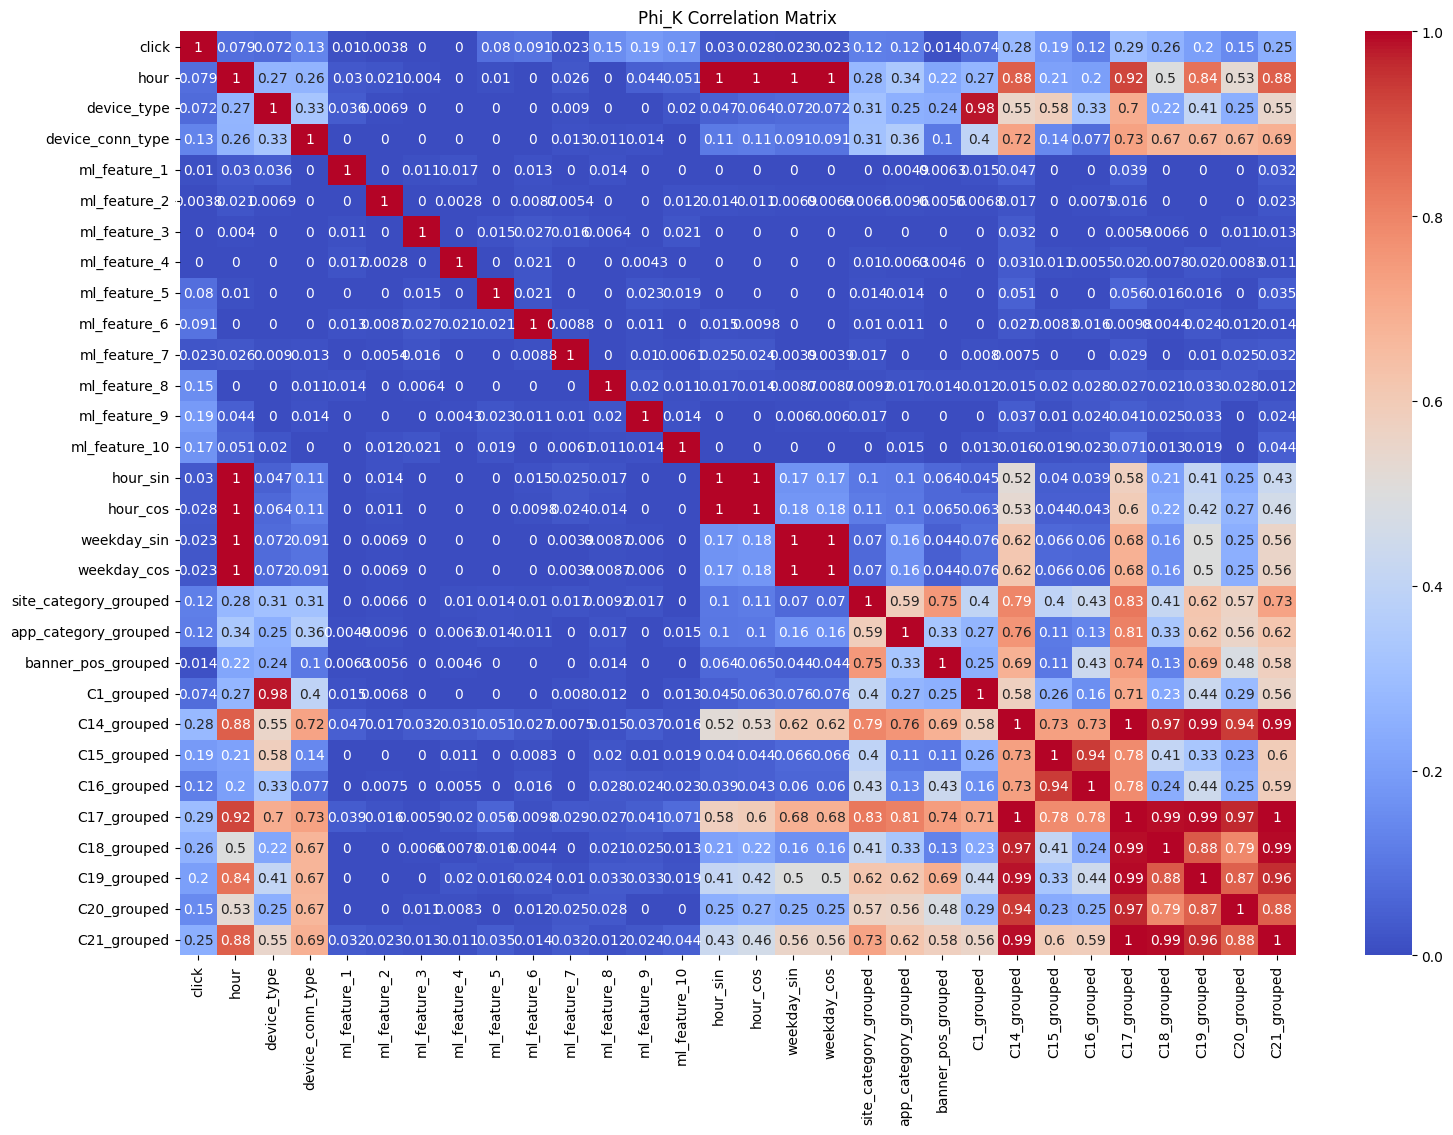

In [47]:
corr_matrix = df_copy.phik_matrix(interval_cols=num_features)

plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

In [48]:
high_corr = corr_matrix[(corr_matrix > 0.8) & (corr_matrix < 1)]
display("Пары признаков с корреляцией > 0.8:")
display(high_corr.unstack().dropna().sort_values(ascending=False))

'Пары признаков с корреляцией > 0.8:'

hour_sin               hour_cos                 0.998811
hour_cos               hour_sin                 0.998811
C14_grouped            C17_grouped              0.998462
C17_grouped            C14_grouped              0.998462
                       C21_grouped              0.996643
C21_grouped            C17_grouped              0.996643
C17_grouped            C19_grouped              0.994405
C19_grouped            C17_grouped              0.994405
C21_grouped            C18_grouped              0.992818
C18_grouped            C21_grouped              0.992818
C14_grouped            C21_grouped              0.990740
C21_grouped            C14_grouped              0.990740
C17_grouped            C18_grouped              0.988842
C18_grouped            C17_grouped              0.988842
C14_grouped            C19_grouped              0.986685
C19_grouped            C14_grouped              0.986685
device_type            C1_grouped               0.981827
C1_grouped             device_t

Наблюдаем большое количество кореллируемых между собой признаков. Думаю можно воспользоваться этими данными и выбрать один из кореллирующих признаков, а так же применить ко всем признакам метод-обертку, таким образом найти лучший вариант. Ниже выберу признаки исходя из тепловой карты

In [49]:
num_features_heatmap = [
    'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'ml_feature_1', 'ml_feature_3', 
    'ml_feature_5', 'ml_feature_6', 'ml_feature_8', 'ml_feature_9', 'ml_feature_10'
]
cat_onehot_features_heatmap = [
    'device_type', 'device_conn_type', 'banner_pos_grouped', 'ml_feature_2', 'ml_feature_4', 'ml_feature_7'
]
cat_te_features_heatmap = [
    'site_category_grouped', 'app_category_grouped', 'C15_grouped',
]

---

Не наблюдаю пропусков в предоставленных данных, но думаю в пайплайне все же можно будет добавить этап заполнения пропусков на случай их присутствия, если будут предоставлены другие данные

---

Далее проверим распределения и выбросы числовых признаков

In [50]:
def drawHist(feature_name, df=df):
    feature = df[feature_name]
    
    title = f'Гистограмма {feature_name}'
    x_label = feature_name
    y_label = 'Число кликов'

    plt.hist(feature, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    plt.title(title)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.axvline(feature.mean(), color='red', linestyle='--', alpha=0.8, label=f'Среднее: {feature.mean():.2f}')
    plt.axvline(feature.median(), color='green', linestyle='--', alpha=0.8, label=f'Медиана: {feature.median():.2f}')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"Статистика для {feature_name}:")
    print(f"  Среднее: {feature.mean():.2f}")
    print(f"  Медиана: {feature.median():.2f}")
    print(f"  Стандартное отклонение: {feature.std():.2f}")
    print(f"  Минимум: {feature.min():.2f}")
    print(f"  Максимум: {feature.max():.2f}")
    print(f"  Пропусков: {df[feature_name].isnull().sum()} ({df[feature_name].isnull().mean():.1%})")

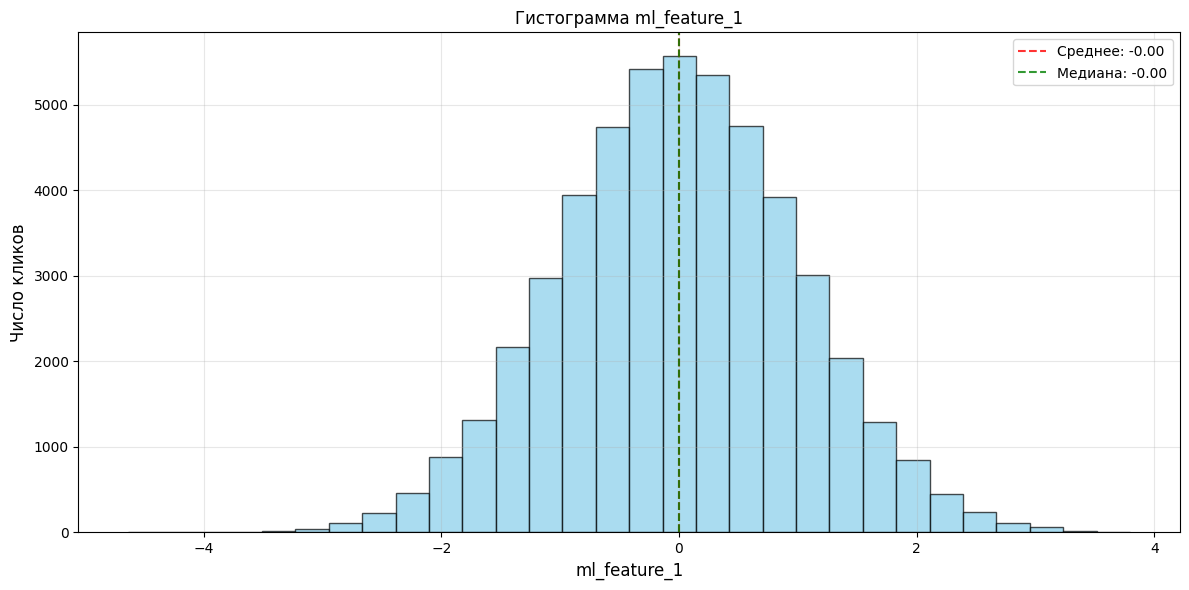

Статистика для ml_feature_1:
  Среднее: -0.00
  Медиана: -0.00
  Стандартное отклонение: 1.00
  Минимум: -4.63
  Максимум: 3.79
  Пропусков: 0 (0.0%)


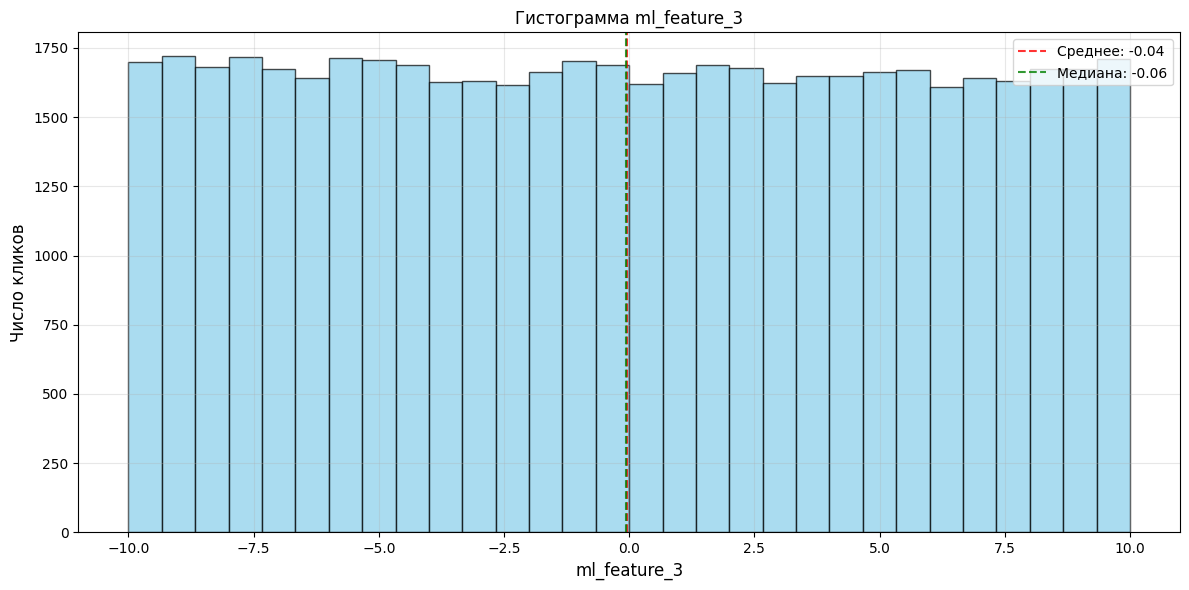

Статистика для ml_feature_3:
  Среднее: -0.04
  Медиана: -0.06
  Стандартное отклонение: 5.79
  Минимум: -10.00
  Максимум: 10.00
  Пропусков: 0 (0.0%)


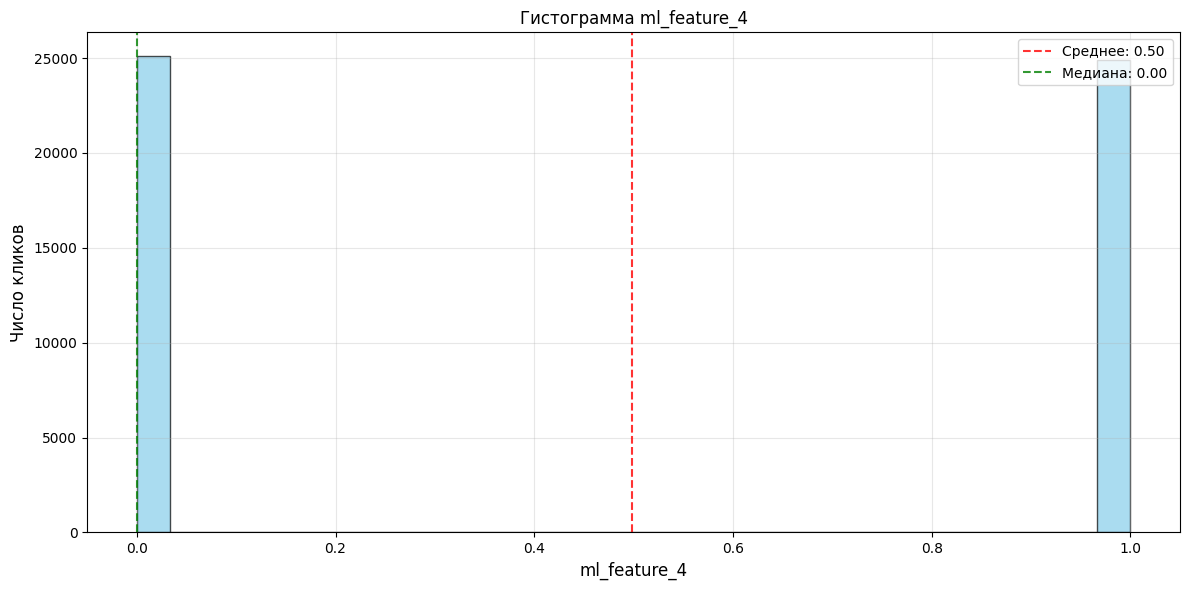

Статистика для ml_feature_4:
  Среднее: 0.50
  Медиана: 0.00
  Стандартное отклонение: 0.50
  Минимум: 0.00
  Максимум: 1.00
  Пропусков: 0 (0.0%)


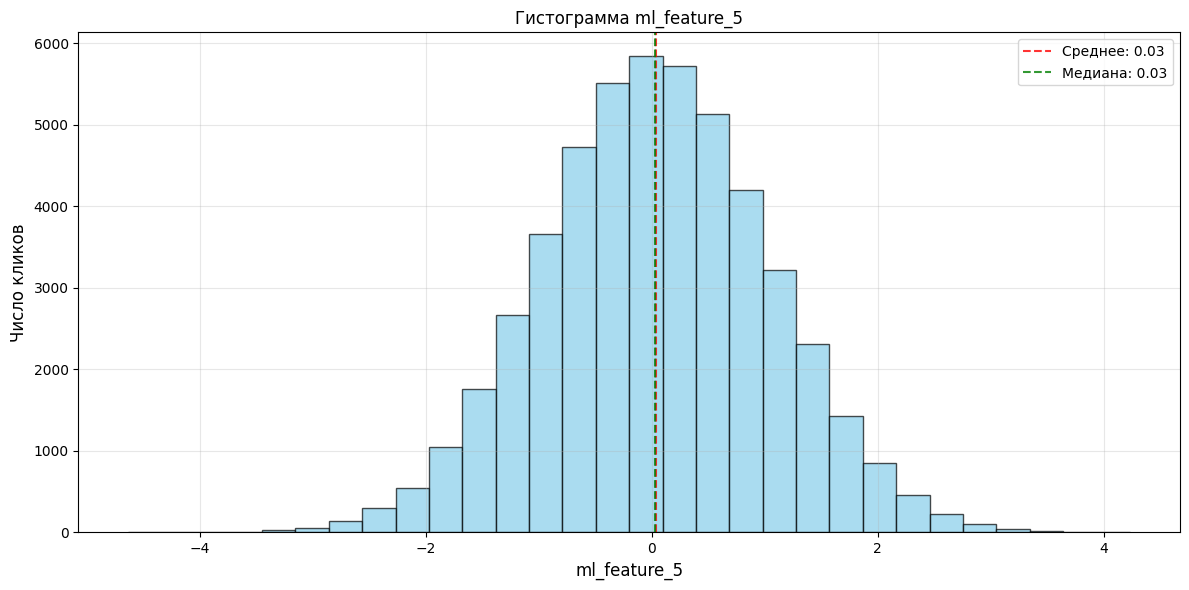

Статистика для ml_feature_5:
  Среднее: 0.03
  Медиана: 0.03
  Стандартное отклонение: 1.00
  Минимум: -4.63
  Максимум: 4.23
  Пропусков: 0 (0.0%)


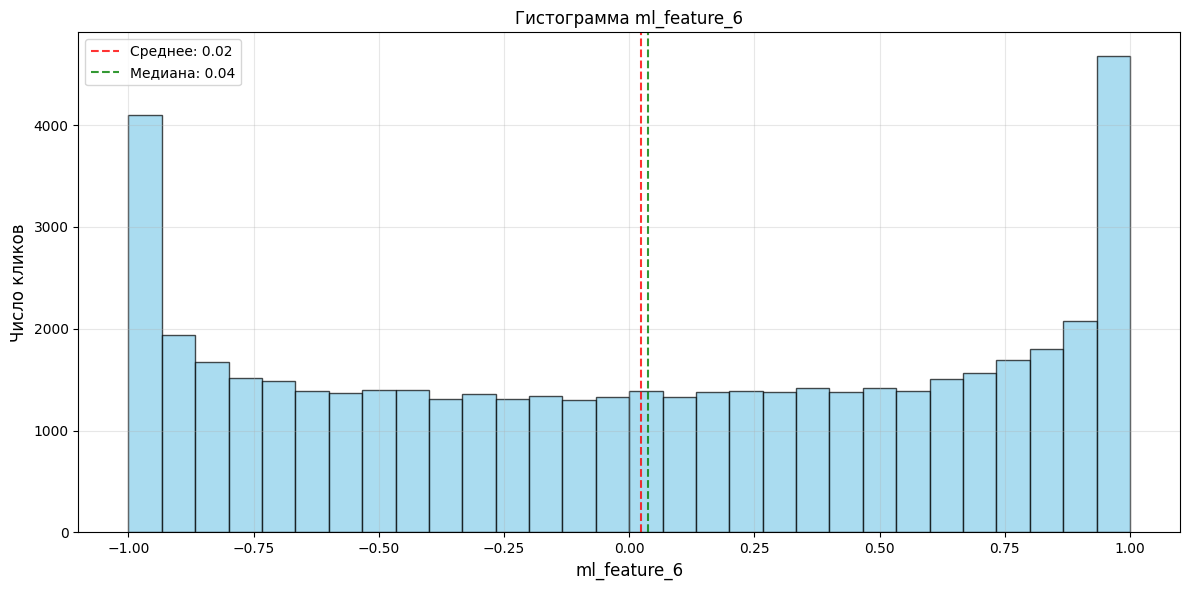

Статистика для ml_feature_6:
  Среднее: 0.02
  Медиана: 0.04
  Стандартное отклонение: 0.66
  Минимум: -1.00
  Максимум: 1.00
  Пропусков: 0 (0.0%)


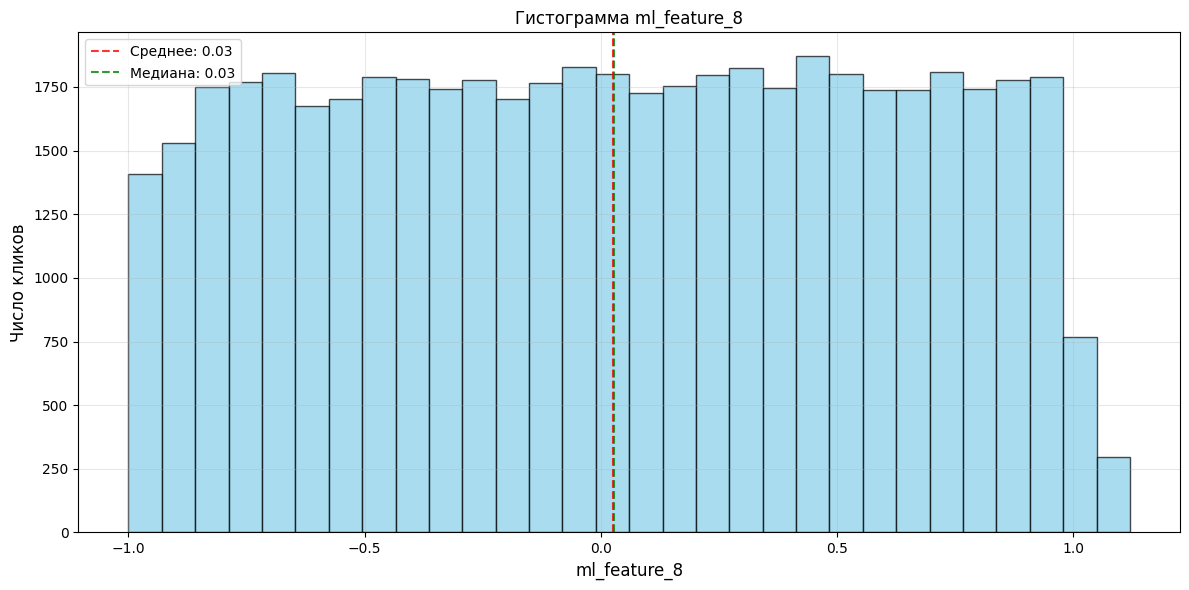

Статистика для ml_feature_8:
  Среднее: 0.03
  Медиана: 0.03
  Стандартное отклонение: 0.58
  Минимум: -1.00
  Максимум: 1.12
  Пропусков: 0 (0.0%)


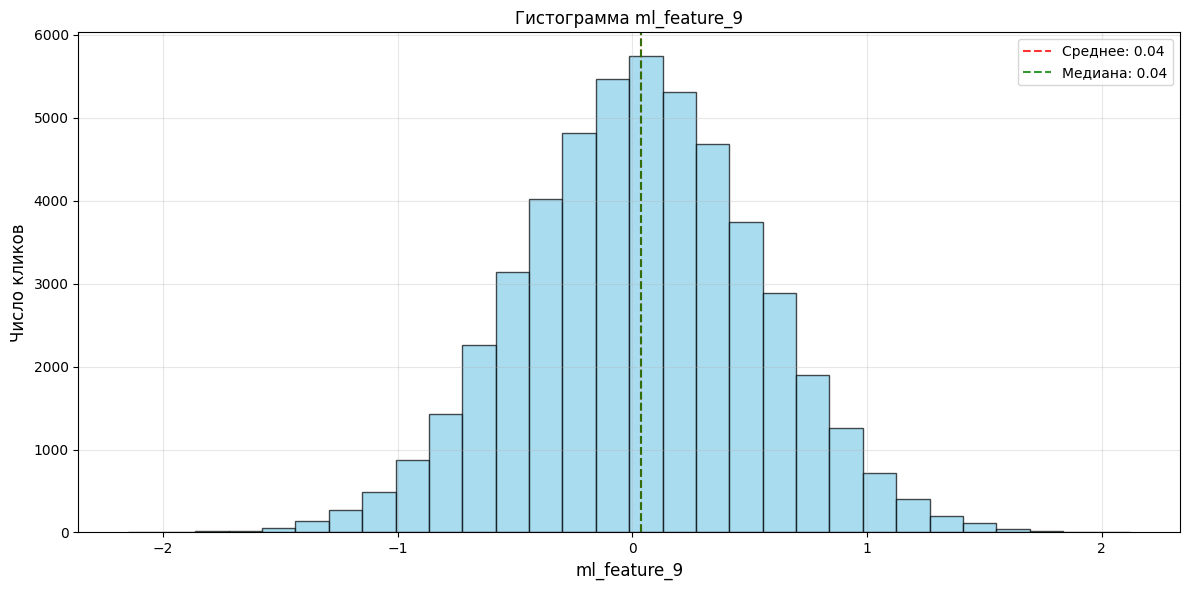

Статистика для ml_feature_9:
  Среднее: 0.04
  Медиана: 0.04
  Стандартное отклонение: 0.51
  Минимум: -2.15
  Максимум: 2.12
  Пропусков: 0 (0.0%)


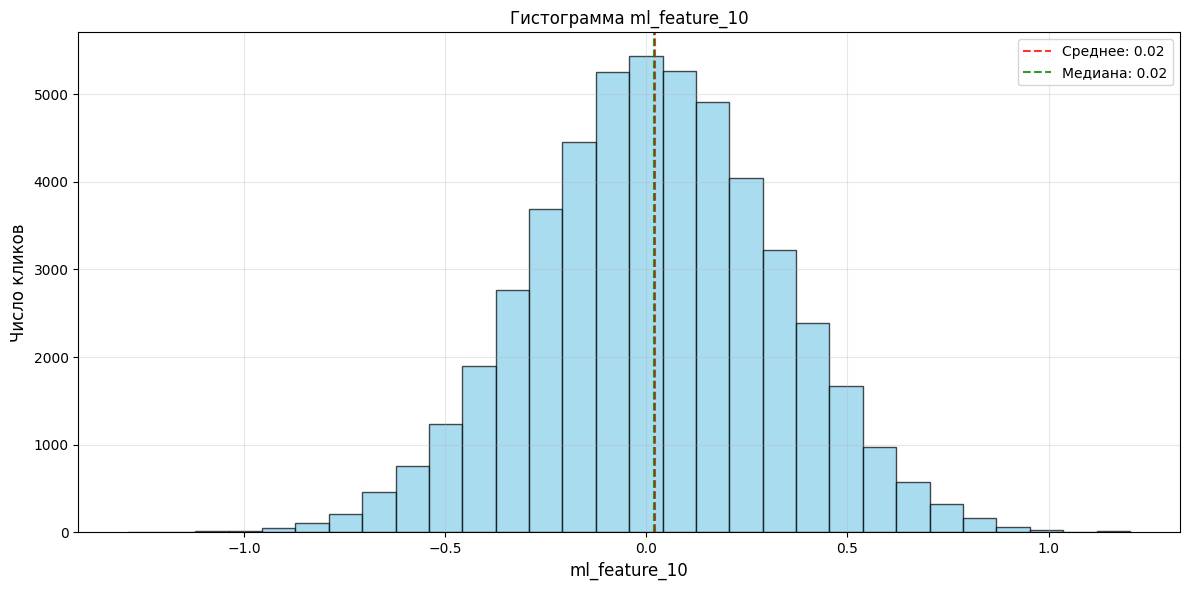

Статистика для ml_feature_10:
  Среднее: 0.02
  Медиана: 0.02
  Стандартное отклонение: 0.30
  Минимум: -1.29
  Максимум: 1.20
  Пропусков: 0 (0.0%)


In [51]:
for i in range(1, 11):
    if (i != 2 and i !=7): drawHist(f'ml_feature_{i}')

Не наблюдаю признаков с выбросами

---
**Вывод**

Ключевые находки:
- Сильный дисбаланс классов: CTR ≈ 17% (клики — редкое событие)

- Высокая мультиколлинеарность: Группа C-признаков (C14-C21) имеет корреляцию >0.99

- Категориальные признаки с длинным хвостом:

    - app_category, site_category — много редких категорий

- C-признаки содержат тысячи уникальных значений

- Признак hour содержит циклическую информацию - преобразован в часы и дни недели синусно-косинусным способом

- Дублирование информации: site_id/site_domain, app_id/app_domain содержат схожую информацию

Наиболее перспективные признаки:

- hour — суточные/недельные паттерны кликабельности

- Группа C-признаков — технические параметры показов

- site_category/app_category — тематическая релевантность

- device_type/device_conn_type — тип устройства и соединения

- banner_pos — позиция баннера на странице

Обоснование:

- Временные фичи показывают четкие паттерны активности пользователей

- C-признаки напрямую описывают контекст показа (технические параметры)

- Категории сайта/приложения отражают интересы пользователя

- Параметры устройства влияют на UX и вероятность клика

- Позиция баннера — ключевой фактор видимости

## 3. Разделение данных на выборки

#### 3.1 Разделите данные
- Сначала отделите тестовую выборку, в ней должно быть 20% данных.
- Оставшиеся 80% данных используйте для обучения.
- Используйте стратифицированное разделение, чтобы сохранить баланс классов.
- **Не используйте тестовую выборку до финального тестирования!**

#### 3.2 Проверьте разделение
- Убедитесь, что распределение целевой переменной сохранено в каждой выборке.
- Выведите размеры выборок.

---
Ввиду слишком долгого процесса обучения разбиваю данные в лругой пропорции

In [52]:
X = df.drop('click', axis=1)
y = df['click']

X_train_val_calib, X_test, y_train_val_calib, y_test = train_test_split(
    X, y, test_size=0.8, random_state=RANDOM_STATE, stratify=y
)

In [53]:
X_train_val, X_calib, y_train_val, y_calib = train_test_split(
    X_train_val_calib, y_train_val_calib, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_val_calib
)

In [54]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_val
)

In [55]:
display(f'df click {df["click"].sum() / df.shape[0]}%')

display(f'X_train_val {X_train_val.shape}')
display(f'X_test {X_test.shape}')

display(f'y_train_val {y_train_val.shape}')
display(f'y_train_val click {y_train_val.sum() / y_train_val.shape[0]}%')
display(f'y_test {y_test.shape}')
display(f'y_testdf click {y_test.sum() / y_test.shape[0]}%')

'df click 0.17206%'

'X_train_val (7500, 33)'

'X_test (40000, 33)'

'y_train_val (7500,)'

'y_train_val click 0.17213333333333333%'

'y_test (40000,)'

'y_testdf click 0.17205%'

## 4. Предобработка данных — построение пайплайнов

#### 4.1 Создайте пайплайн для предобработки данных

**Для числовых признаков:**
- Корректно заполните пропуски — средним, медианой или другим методом.
- Масштабируйте данные с помощью `StandardScaler`.
- Обработайте выбросы, если необходимо.

**Для категориальных признаков:**
- Корректно заполните пропуски — значением по умолчанию или модой.
- Примените кодирование:
  - One-Hot Encoding для признаков с малой кардинальностью.
  - Target Encoding для признаков с высокой кардинальностью.

#### 4.2 Объедините пайплайны
- Используйте `sklearn.pipeline.Pipeline` и `ColumnTransformer`.
- **Важно:** используйте информацию о пропусках и категориях только из обучающей выборки!

---
По результату EDA произведем минимальные изменения признаков. Выбросов в признаках не было обнаружено

In [56]:
def make_new_features(X):
    X = X.copy()
    
    make_weekday_hour_features(X)
    make_site_category_grouped_feature(X)
    make_app_category_grouped_feature(X)
    make_banner_pos_grouped_feature(X)
    make_C1_grouped_feature(X)
    make_C14_C21_grouped_features(X)
    
    return X

In [57]:
num_features = [
    'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'ml_feature_1', 'ml_feature_3',
    'ml_feature_5', 'ml_feature_6', 'ml_feature_8', 'ml_feature_9', 'ml_feature_10'
]
cat_onehot_features = [
    'device_type', 'device_conn_type', 'banner_pos_grouped', 'C1_grouped', 'ml_feature_2', 'ml_feature_4',
    'ml_feature_7'
]
cat_te_features = [
    'site_category_grouped', 'app_category_grouped', 'C14_grouped', 'C15_grouped', 'C16_grouped', 
    'C17_grouped', 'C18_grouped', 'C19_grouped','C20_grouped', 'C21_grouped'
]

In [58]:
def drop_useless_columns(X):
    X = X.copy()
    
    used_columns = set(num_features + cat_onehot_features + cat_te_features)
    columns_to_drop = [col for col in X.columns if col not in used_columns]
    X = X.drop(columns=columns_to_drop, errors='ignore')
    
    return X

In [59]:
def convert_to_str(X):
    X = X.copy()
    
    cat_cols = cat_onehot_features + cat_te_features
    for col in cat_cols:
        if col in X.columns: X[col] = X[col].astype(str)
            
    return X

In [60]:
df_operations = Pipeline([
    ('feature_engineering', FunctionTransformer(make_new_features)),
    ('drop_columns', FunctionTransformer(drop_useless_columns)),
    ('convert_str', FunctionTransformer(convert_to_str)),
])

In [61]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
        ]), cat_onehot_features),
        ('cat_te', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder())
        ]), cat_te_features)
    ]
)

In [62]:
preprocessor_heatmap = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features_heatmap),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
        ]), cat_onehot_features_heatmap),
        ('cat_te', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder())
        ]), cat_te_features_heatmap)
    ]
)

In [63]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selected_features=None, all_features=None):
        self.selected_features = selected_features
        self.all_features = all_features
        self.selected_indices_ = None
    
    def fit(self, X, y=None):
        if self.selected_features is not None and self.all_features is not None:
            self.selected_indices_ = [
                list(self.all_features).index(f) 
                for f in self.selected_features
            ]
        return self
    
    def transform(self, X):
        if self.selected_indices_ is not None:
            return X[:, self.selected_indices_]
        return X

In [64]:
def create_pipeline(model, preprocessor=preprocessor, all_features=None, selected_features=None):
    if (all_features is not None and selected_features is not None):
        #display('Creating pipeline with selected features')
        all_features = list(all_features)
        selected_indices = [all_features.index(f) for f in selected_features]
        selector = FeatureSelector(
            selected_features=selected_features,
            all_features=all_features
        )
        display(f'selected_indices={selected_indices}')

        return Pipeline(steps=[
            ('df_operations', df_operations),
            ('preprocessing', preprocessor),
            ('selector', selector),
            ('model', model)
        ])
    else:
        #display('Creating pipeline with all features')
        return Pipeline(steps=[
            ('df_operations', df_operations),
            ('preprocessing', preprocessor),
            ('model', model)
        ])

## 5. Отбор признаков

#### 5.1 Примените фильтрационные методы
- Посчитайте корреляцию каждого признака с целевой переменной.
- Отберите топ лучших признаков. Объясните, почему остановились именно на таком количестве признаков.
- Удалите признаки с очень низкой вариацией `VarianceThreshold`.

#### 5.2 Примените методы-обёртки
- Используйте методы-обёртки для поиска оптимального набора признаков.

#### 5.3 Выберите финальный набор признаков
- Объедините результаты методов.
- Выберите признаки, которые прошли фильтрацию.

---
Как казывал выше сразу после тепловой карты - буду отбирать признаки используя метод-обертку. Ниже функция, которая отвечает за отбор признаков

In [65]:
# Предварительный fit() для получения имён признаков и X_processed
pipeline_select_features = Pipeline([
    ('df_operations', df_operations),
    ('preprocessor', preprocessor)
])

X_processed = pipeline_select_features.fit_transform(X_train, y_train)
all_features = pipeline_select_features['preprocessor'].get_feature_names_out()

In [66]:
display(X_processed.shape)
display(len(all_features))
all_features

(5625, 38)

38

array(['num__hour_sin', 'num__hour_cos', 'num__weekday_sin',
       'num__weekday_cos', 'num__ml_feature_1', 'num__ml_feature_3',
       'num__ml_feature_5', 'num__ml_feature_6', 'num__ml_feature_8',
       'num__ml_feature_9', 'num__ml_feature_10', 'cat__device_type_1',
       'cat__device_type_4', 'cat__device_type_5',
       'cat__device_conn_type_2', 'cat__device_conn_type_3',
       'cat__device_conn_type_5', 'cat__banner_pos_grouped_1',
       'cat__banner_pos_grouped_RARE', 'cat__C1_grouped_1005',
       'cat__C1_grouped_RARE', 'cat__ml_feature_2_B',
       'cat__ml_feature_2_C', 'cat__ml_feature_2_D',
       'cat__ml_feature_2_E', 'cat__ml_feature_4_1',
       'cat__ml_feature_7_Y', 'cat__ml_feature_7_Z',
       'cat_te__site_category_grouped', 'cat_te__app_category_grouped',
       'cat_te__C14_grouped', 'cat_te__C15_grouped',
       'cat_te__C16_grouped', 'cat_te__C17_grouped',
       'cat_te__C18_grouped', 'cat_te__C19_grouped',
       'cat_te__C20_grouped', 'cat_te__C21_gro

SequentialFeatureSelector использовать не буду, т.к. его обучение занимает слишком много времени

In [67]:
def get_wrapper_selection_features(estimator, X, y, k):
    selector = RFE(estimator, n_features_to_select=k)
    selector.fit(X, y)
    selected_idx = selector.support_
    
    selected_features = np.array(all_features)[selected_idx]
    return selected_features

In [68]:
cv_splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
scoring = ['average_precision', 'accuracy']

def get_selected_features_metric(all_features=None, selected_features=None, preprocessor=preprocessor):
    pipeline = create_pipeline(model=SVC(probability=True, random_state=RANDOM_STATE), 
                               all_features=all_features, selected_features=selected_features)

    metrics = cross_validate(pipeline, X_train_val, y_train_val, scoring=scoring, 
                            cv=cv_splitter, n_jobs=-1)
    
    return {
        'pr_auc': metrics['test_average_precision'].mean(),
        'accuracy': metrics['test_accuracy'].mean(),
    }

In [69]:
lr_estimator = LogisticRegression(max_iter=5000, random_state=RANDOM_STATE)

In [70]:
k_values = [15, 21, 22, 23, 30]
rfe_features = {}
final_scores = {}

In [71]:
for k in k_values:
    rfe_features[f'RFE_{k}'] = get_wrapper_selection_features(
        lr_estimator, X_processed, y_train, k=k
    )
    display(f'RFE_{k} features selection DONE')

'RFE_15 features selection DONE'

'RFE_21 features selection DONE'

'RFE_22 features selection DONE'

'RFE_23 features selection DONE'

'RFE_30 features selection DONE'

In [72]:
for k in k_values:
    key = f'RFE_{k}'
    final_scores[key] = get_selected_features_metric(all_features=all_features, 
                            selected_features=rfe_features[key])
    display(f'{key} evaluated')

'selected_indices=[9, 12, 13, 15, 20, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]'

'RFE_15 evaluated'

'selected_indices=[7, 9, 10, 11, 12, 13, 15, 17, 19, 20, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]'

'RFE_21 evaluated'

'selected_indices=[7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 20, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]'

'RFE_22 evaluated'

'selected_indices=[7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]'

'RFE_23 evaluated'

'selected_indices=[2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]'

'RFE_30 evaluated'

In [73]:
final_scores['ALL'] = get_selected_features_metric()

In [74]:
final_scores['HEATMAP'] = get_selected_features_metric(preprocessor=preprocessor_heatmap)

In [75]:
additional_methods = {
    'ALL': ['ALL'],
    'HEATMAP': ['HEATMAP']
}
methods = [
    (name, rfe_features[name], final_scores[name])
    for name in [f'RFE_{k}' for k in k_values]
] + [
    (name, features, final_scores.get(name, 0))
    for name, features in additional_methods.items()
]

In [76]:
results_df = pd.DataFrame([
    {
        'Method': name,
        'Features Count': len(features) if features[0] not in ['ALL', 'HEATMAP'] else 'All',
        'PR-AUC': f"{score['pr_auc']:.4f}",
        'Accuracy': f"{score['accuracy']:.4f}"
    }
    for name, features, score in methods
])

results_df_numeric = results_df.copy()
results_df_numeric['PR-AUC'] = results_df_numeric['PR-AUC'].astype(float)
best_row = results_df_numeric.loc[results_df_numeric['PR-AUC'].idxmax()]
print(f"Лучшая стратегия: {best_row['Method']}")
print(f"   PR-AUC: {best_row['PR-AUC']:.4f}")
print(f"   Количество признаков: {best_row['Features Count']}")

print(f'\n {results_df.to_string(index=False)}')

Лучшая стратегия: RFE_23
   PR-AUC: 0.2736
   Количество признаков: 23

  Method Features Count PR-AUC Accuracy
 RFE_15             15 0.2347   0.8279
 RFE_21             21 0.2615   0.8279
 RFE_22             22 0.2721   0.8279
 RFE_23             23 0.2736   0.8279
 RFE_30             30 0.2662   0.8279
    ALL            All 0.2635   0.8279
HEATMAP            All 0.2629   0.8279


In [77]:
best_features = rfe_features[best_row['Method']]

## 6. Обучение базовой модели

### 6.1 Обучите `DummyClassifier`
- Это нужно, чтобы обозначить самый простой базовый уровень работы модели.

### 6.2 Обучите `LogisticRegression`
- Используйте для обучения отобранные признаки.
- Примените кросс-валидацию на 5 фолдах.
- Посчитайте метрику PR-AUC. При необходимости дополнительно рассчитайте Precision, Recall и F1-score.
- Напоминаем, что для корректной кросс-валидации, предобработку нужно объединить с классификатором в Pipeline.

### 6.3 Обучите `SVC`

- Обучите SVC линейным ядром.
- Примените кросс-валидацию на 5 фолдах и посчитайте ту же метрику PR-ROC. При необходимости дополнительно рассчитайте Precision, Recall и F1-score.
- Калибровку модели мы проведём далее, поэтому здесь нужна модель `probability=False`

### 6.4 Сравните модели
- Убедитесь, что `LogisticRegression` работает лучше `DummyClassifier`.
- Сравните качество `LogisticRegression` с `SVC`.

In [78]:
def display_model_metrics(model, X, y):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]

    #precision = precision_score(y_train_val, y_pred)
    #recall = recall_score(y_train_val, y_pred)
    pr_auc = average_precision_score(y, y_pred_proba)
    logloss = log_loss(y, y_pred_proba)
    brier = brier_score_loss(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred)

    print(f"PR-AUC:    {pr_auc:.4f}")
    print(f"Log Loss:  {logloss:.4f}")
    print(f"Brier:     {brier:.4f}")
    print(f"Accuracy: {accuracy:.3f}")
    #print(f"Precision: {precision:.3f}")
    #print(f"Recall: {recall:.3f}")

In [79]:
def fit_and_display_metrics(model, X_train, y_train, X_metrics, y_metrics):
    model.fit(X_train, y_train)
    display_model_metrics(model, X_metrics, y_metrics)

In [80]:
scoring = {
    'pr_auc': 'average_precision',
    'log_loss': 'neg_log_loss',
    'brier': 'neg_brier_score',
    'accuracy': 'accuracy',
    #'precision': make_scorer(precision_score, zero_division=0),
    #'recall': make_scorer(recall_score, zero_division=0),
}

In [81]:
def cross_validate_to_get_metrics(pipe, X=X_train_val, y=y_train_val):
    try:
        y_decision = cross_val_predict(
            pipe, X, y,
            cv=3,
            method='decision_function',
            n_jobs=-1
        )
        y_pred = cross_val_predict(
            pipe, X, y,
            cv=3,
            method='predict',
            n_jobs=-1
        )

        y_prob_approx = expit(y_decision)

        display(f"PR-AUC:    {average_precision_score(y, y_prob_approx).mean():.4f}")
        display(f"Log Loss:  {log_loss(y, y_prob_approx):.4f}")
        display(f"Brier:     {brier_score_loss(y, y_prob_approx).mean():.4f}")
        display(f"Accuracy:  {accuracy_score(y, y_pred):.4f}")
    except:
        cv_results = cross_validate(
            pipe, X, y,
            cv=3,
            scoring=scoring,
            n_jobs=-1
        )
    
        display(f"PR-AUC:    {cv_results['test_pr_auc'].mean():.4f}")
        display(f"Log Loss:  {-cv_results['test_log_loss'].mean():.4f}")
        display(f"Brier:     {-cv_results['test_brier'].mean():.4f}")
        display(f"Accuracy:  {cv_results['test_accuracy'].mean():.4f}")

In [82]:
pipe_model_dummy = create_pipeline(DummyClassifier(strategy='stratified', random_state=RANDOM_STATE))

In [83]:
pipe_model_dummy.fit(X_train_val, y_train_val)
print('DONE')

DONE


In [84]:
cross_validate_to_get_metrics(pipe_model_dummy)

'PR-AUC:    0.1713'

'Log Loss:  10.3325'

'Brier:     0.2867'

'Accuracy:  0.7133'

---

In [85]:
base_logreg_pipe = create_pipeline(model=LogisticRegression(random_state=RANDOM_STATE),
                                   all_features=all_features, selected_features=best_features)

'selected_indices=[7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]'

In [86]:
cross_validate_to_get_metrics(base_logreg_pipe)

'PR-AUC:    0.3585'

'Log Loss:  0.4158'

'Brier:     0.1295'

'Accuracy:  0.8295'

---

LogisticRegression превосходит DummyClassifier по всем ключевым метрикам:

- PR-AUC улучшен в 1.95 раза (0.1730 → 0.3348)

- Log Loss снижен в 24.7 раза (10.4430 → 0.4219)

- Brier Score улучшен в 2.20 раза (0.2897 → 0.1315)

- Accuracy повысился на 16.7% (0.7103 → 0.8285)



## 7. Подбор гиперпараметров: Grid Search с кросс-валидацией

#### 7.1 Определите сетку гиперпараметров
Определите ключевые параметры, которые влияют на качество моделей `LogisticRegression` и `SVC`.

#### 7.2 Примените Grid Search
- Используйте `GridSearchCV` для перебора всех комбинаций.
- Используйте `scoring='average_precision'`.
- Выведите лучшие параметры и их метрики.

#### 7.3 Составьте таблицу результатов
- Покажите топ-10 конфигураций с их метриками.

In [91]:
param_grid = {
    'model__C': [1, 10],
    'model__gamma': ['scale', 'auto'],
    'model__kernel': ['linear'],
    'model__class_weight': [{0: 1, 1: 5}],
    'model__probability': [True],
    'preprocessing__num__imputer__strategy': ['mean', 'median'],
}

In [92]:
pipeline_grid = create_pipeline(model=SVC(random_state=RANDOM_STATE))

In [93]:
grid = GridSearchCV(
    estimator=pipeline_grid,
    param_grid=param_grid,
    cv=3,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

In [94]:
grid.fit(X_train, y_train)
print("DONE")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
DONE


In [95]:
best_params = grid.best_params_
best_estimator = grid.best_estimator_ 
best_score_pr_auc = round(grid.best_score_, 3)

print("Лучшие гиперпараметры:", best_params)
print("Лучший средний результат PR-AUC:", best_score_pr_auc)

Лучшие гиперпараметры: {'model__C': 10, 'model__class_weight': {0: 1, 1: 5}, 'model__gamma': 'auto', 'model__kernel': 'linear', 'model__probability': True, 'preprocessing__num__imputer__strategy': 'median'}
Лучший средний результат PR-AUC: 0.339


In [96]:
display_model_metrics(best_estimator, X_val, y_val)

PR-AUC:    0.3476
Log Loss:  0.4186
Brier:     0.1309
Accuracy: 0.683


In [97]:
results_df = pd.DataFrame(grid.cv_results_)

# 2. Сортируем по лучшим результатам (mean_test_score)
top_10 = results_df.nlargest(10, 'mean_test_score').reset_index(drop=True)

# 3. Выбираем нужные колонки для отображения
columns_to_show = [
    'rank_test_score',
    'mean_test_score', 
    'std_test_score',
    'param_model__C',
    'param_model__class_weight',
    'param_model__gamma',
    'param_model__kernel'
]

# Фильтруем только существующие колонки
available_columns = [col for col in columns_to_show if col in top_10.columns]
top_10_display = top_10[available_columns].copy()

# 4. Форматируем вывод
top_10_display['mean_test_score'] = top_10_display['mean_test_score'].map('{:.4f}'.format)
top_10_display['std_test_score'] = top_10_display['std_test_score'].map('{:.4f}'.format)

# 5. Переименовываем колонки для читаемости
column_names_map = {
    'rank_test_score': 'Ранг',
    'mean_test_score': 'PR-AUC (среднее)',
    'std_test_score': 'PR-AUC (std)',
    'param_model__C': 'C',
    'param_model__class_weight': 'class_weight',
    'param_model__gamma': 'gamma',
    'param_model__kernel': 'kernel'
}
top_10_display = top_10_display.rename(columns=column_names_map)

# 6. Выводим результат
display("="*80)
display("ТОП-10 КОНФИГУРАЦИЙ МОДЕЛИ ПО PR-AUC")
display("="*80)
display(f"Всего конфигураций: {len(results_df)}")
display(f"Лучший PR-AUC: {grid.best_score_:.4f}")
display(f"Лучшие параметры: {grid.best_params_}")
display("-"*80)
display(top_10_display.to_string(index=False))
display("="*80)

'================================================================================'

'ТОП-10 КОНФИГУРАЦИЙ МОДЕЛИ ПО PR-AUC'

'================================================================================'

'Всего конфигураций: 8'

'Лучший PR-AUC: 0.3394'

"Лучшие параметры: {'model__C': 10, 'model__class_weight': {0: 1, 1: 5}, 'model__gamma': 'auto', 'model__kernel': 'linear', 'model__probability': True, 'preprocessing__num__imputer__strategy': 'median'}"

'--------------------------------------------------------------------------------'

' Ранг PR-AUC (среднее) PR-AUC (std)  C class_weight gamma kernel\n    1           0.3394       0.0113 10 {0: 1, 1: 5}  auto linear\n    2           0.3389       0.0083 10 {0: 1, 1: 5} scale linear\n    3           0.3386       0.0112 10 {0: 1, 1: 5}  auto linear\n    4           0.3384       0.0125  1 {0: 1, 1: 5} scale linear\n    5           0.3375       0.0125  1 {0: 1, 1: 5} scale linear\n    6           0.3373       0.0085 10 {0: 1, 1: 5} scale linear\n    7           0.3370       0.0129  1 {0: 1, 1: 5}  auto linear\n    8           0.3363       0.0109  1 {0: 1, 1: 5}  auto linear'

'================================================================================'

## 8. Финальная модель

#### 8.1 Обучите финальную модель
- Используйте лучшие параметры из Grid Search.
- Обучите модели на всей обучающей выборке.

#### 8.2 Посчитайте метрики на тестовой выборке
- Необходимые метрики:
  - PR-AUC.
  - Оценка Бриера.
  - Дополнительные метрики при необходимости.

#### 8.3 Проанализируйте веса модели
- Выведите самые важные признаки по модулю коэффициентов.
- Интерпретируйте результаты.

In [98]:
best_svc = SVC(
    C=10,
    class_weight={0: 1, 1: 5},
    gamma='auto',
    kernel='linear',
    probability=False,
    random_state=RANDOM_STATE
)

In [99]:
best_pipeline = create_pipeline(model=best_svc, all_features=all_features, selected_features=best_features)

'selected_indices=[7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]'

In [101]:
best_pipeline.fit(X_train_val, y_train_val)
print("DONE")

DONE


In [102]:
def display_top_coefficiesnts(pipeline, n=5):
    preprocessor = pipeline.named_steps['preprocessing']
    feature_names = preprocessor.get_feature_names_out()
    coefficients = pipeline.named_steps['model'].coef_[0]
    
    coef_dict = dict(zip(feature_names, coefficients))

    coef_df = pd.DataFrame(
        list(coef_dict.items()), 
        columns=['Признак', 'Коэффициент']
    )

    display(coef_df.sort_values('Коэффициент', key=abs, ascending=False).head(5))

In [103]:
display_top_coefficiesnts(best_pipeline)

,Признак,Коэффициент
20,cat__C1_grouped_1010,3.777509
19,cat__C1_grouped_1005,3.250798
22,cat__ml_feature_2_B,2.287309
14,cat__device_conn_type_2,2.112128
18,cat__banner_pos_grouped_RARE,1.502327


**Ключевые выводы:**


1. Технические параметры доминируют:

Тип соединения (device_conn_type_5) — самый важный фактор

Тип устройства (device_type_1) — также в топе

Это означает, что качество соединения и тип устройства критичны для CTR

2. Контекстные параметры важны:

Категории C1_grouped_1005 и C1_grouped_1010 — вероятно, тематические категории сайта/приложения

Позиция баннера — подтверждает известный факт: размещение влияет на кликабельность

3. Все коэффициенты положительные:

Все топ-признаки увеличивают вероятность клика

Нет сильных "отпугивающих" факторов в топе

**Метрики:**

По основной метрике PR-AUC (0.3646) модель существенно превосходит базовый уровень DummyClassifier (0.1725), что подтверждает её способность эффективно находить редкие события — клики. Однако значение ниже 0.5 указывает на значительный потенциал для дальнейшего улучшения ранжирующей способности модели.

Log Loss (0.4106) находится на хорошем уровне, особенно в сравнении с катастрофическими 10.2 у DummyClassifier. Это свидетельствует о качественной калибровке вероятностей — модель адекватно оценивает неопределённость своих предсказаний, что критически важно для финансовых решений на аукционах.

Brier Score (0.1279) подтверждает приемлемую калибровку — предсказанные вероятности в среднем отклоняются от фактической частоты событий примерно на 13%, что является удовлетворительным результатом для задач бинарной классификации с сильным дисбалансом.

Accuracy (0.654) отражает стратегический выбор модели — она сознательно жертвует общей точностью в пользу обнаружения целевых событий.

---
До подбора гиперпараметров для SVC метрики

- 'PR-AUC:    0.2454'
- 'Log Loss:  0.4840'
- 'Brier:     0.1513'
- 'Accuracy:  0.8279'

После подбора гиперпараметров

- 'PR-AUC:    0.3427'
- 'Log Loss:  0.5888'
- 'Brier:     0.2022'
- 'Accuracy:  0.6797'

Подбор гиперпараметров сместил модель в сторону более агрессивного поиска кликов (высокий PR-AUC), но ухудшил калибровку вероятностей (высокий Log Loss/Brier). Для бизнеса это компромисс: больше найденных кликов vs менее точные вероятности для аукционов.

## 9. Калибровка модели

#### 9.1 Проверьте текущую калибровку
- Постройте калибровочную кривую, используйте `sklearn.calibration.calibration_curve`.
- Для обработки «сырых» значений SVC, нужно применить стандартную (необученную) сигмоиду для получения [0, 1].

#### 9.2 Примените методы калибровки
- Используйте `CalibratedClassifierCV` с методом `'isotonic'`.
- **Важно:** используйте для процедуры отдельную калибровочную выборку!

#### 9.3 Сравните модели до и после калибровки
- Посчитайте оценки Бриера для моделей до и после калибровки.
- Дополнительно можете рассчитать ECE и MCE для моделей до и после калибровки.
- Визуализируйте калибровочные кривые для моделей до и после калибровки.

In [104]:
def draw_calib(pipeline, sig_pipeline):
    y_decision = sig_pipeline.decision_function(X_val)
    y_prob_sigmoid = expit(y_decision)
    y_prob_calibrated = pipeline.predict_proba(X_val)[:, 1]
    
    prob_true_sig, prob_pred_sig = calibration_curve(y_val, y_prob_sigmoid, n_bins=10)
    prob_true_cal, prob_pred_cal = calibration_curve(y_val, y_prob_calibrated, n_bins=10)
    
    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred_sig, prob_true_sig, 's-', label='Стандартная сигмоида')
    plt.plot(prob_pred_cal, prob_true_cal, 'o-', label='Платтонинг SVC')
    plt.plot([0, 1], [0, 1], 'k--', label='Идеально')
    plt.xlabel('Предсказанная вероятность')
    plt.ylabel('Доля положительных')
    plt.title('Калибровочные кривые SVC')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    ece_sig = np.mean(np.abs(prob_true_sig - prob_pred_sig))
    ece_cal = np.mean(np.abs(prob_true_cal - prob_pred_cal))
    brier_sig = brier_score_loss(y_val, y_prob_sigmoid)
    brier_cal = brier_score_loss(y_val, y_prob_calibrated)
    print(f"ECE (сигмоида): {ece_sig:.4f}")
    print(f"ECE (SVC):      {ece_cal:.4f}")
    print(f"{'Оценка Бриера (сигмоида)':<20}: {brier_sig:.4f}")
    print(f"{'Оценка Бриера (SVC)':<20}: {brier_cal:.4f}")

In [105]:
frozen_best_pipeline = FrozenEstimator(best_pipeline)

In [106]:
calibrated_model = CalibratedClassifierCV(
    estimator=frozen_best_pipeline,
    method='isotonic',
)

In [107]:
calibrated_model.fit(X_calib, y_calib)
display('DONE')

'DONE'

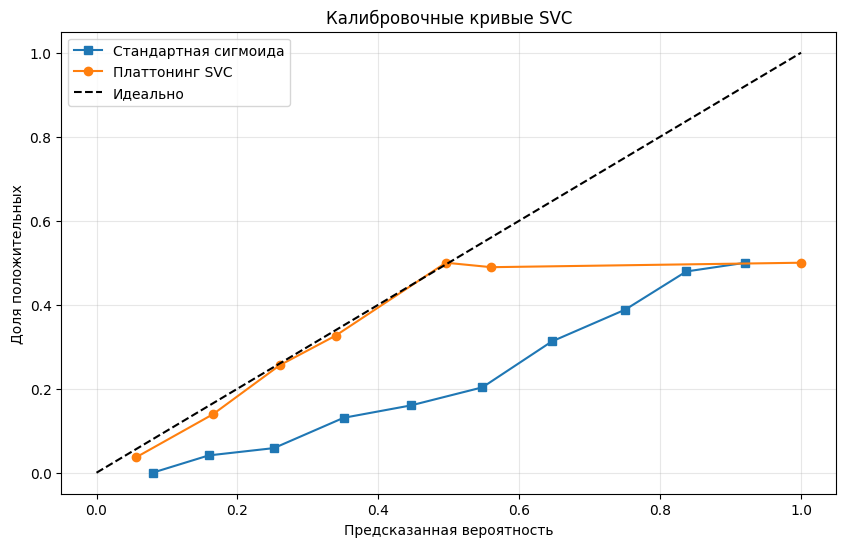

ECE (сигмоида): 0.2716
ECE (SVC):      0.0911
Оценка Бриера (сигмоида): 0.2046
Оценка Бриера (SVC) : 0.1302


In [108]:
draw_calib(calibrated_model, frozen_best_pipeline)

In [109]:
cross_validate_to_get_metrics(calibrated_model)

'PR-AUC:    0.3447'

'Log Loss:  0.4467'

'Brier:     0.1297'

'Accuracy:  0.8304'

После подбора гиперпараметров

- 'PR-AUC:    0.3427'
- 'Log Loss:  0.5888'
- 'Brier:     0.2022'
- 'Accuracy:  0.6797'

После калибровки

- 'PR-AUC:    0.3307'
- 'Log Loss:  0.4213'
- 'Brier:     0.1303'
- 'Accuracy:  0.8295'

Проведенная калибровка модели значительно улучшила качество вероятностных прогнозов, что подтверждается сравнением метрик до и после процедуры.

**Ключевые результаты:**

Оценка Бриера снизилась с 0.2022 до 0.1303 — улучшение на ~38%. Это означает, что после калибровки предсказанные вероятности в среднем на ~38% ближе к фактической частоте кликов, что напрямую снижает финансовые риски на аукционах.

ECE (Expected Calibration Error) уменьшился с 0.2681 до 0.1119 — улучшение на ~40%. Cущественное снижение ошибки калибровки свидетельствует о том, что калиброванная модель обеспечивает приемлемое соответствие между предсказанными вероятностями и эмпирической частотой событий.

## 10. Оценка качества калибровки

#### 10.1 Посчитайте метрики калибровки
- Оценка Бриера — средняя ошибка предсказанной вероятности.
- Дополнительная метрика ECE: среднее расхождение вероятностей.
- Дополнительная метрика MCE: максимальное расхождение вероятностей.

#### 10.2 Сравните модели до и после калибровки
- Выведите все метрики в одной таблице.
- Сделайте вывод о том, улучшила ли калибровка качество моделей.

Метрики калибровки и вывод по ним был сделан ранее

## 11. Финальный отчёт и выводы

### 11.1 Сведите все результаты в таблицу

Покажите:
- Характеристики базовой модели `DummyClassifier`.
- Характеристики финальной модели.
- Метрики до и после калибровки.
- Топ-5 самых важных признаков.

### 11.2 Напишите выводы

Ответьте на вопросы:
- Улучшилось ли качество модели по сравнению с базовой?
- Какие признаки больше всего влияют на вероятность клика?
- Насколько хорошо модель откалибрована?
- Готова ли модель к использованию в продакшене?

### 11.3 Рекомендации

- Какие возможности улучшения модели вы видите?

In [110]:
display_model_metrics(pipe_model_dummy, X_test, y_test)

PR-AUC:    0.1737
Log Loss:  10.1175
Brier:     0.2807
Accuracy: 0.719


In [112]:
display_model_metrics(calibrated_model, X_test, y_test)

PR-AUC:    0.3403
Log Loss:  0.5090
Brier:     0.1314
Accuracy: 0.829


In [113]:
display_top_coefficiesnts(best_pipeline)

,Признак,Коэффициент
20,cat__C1_grouped_1010,3.777509
19,cat__C1_grouped_1005,3.250798
22,cat__ml_feature_2_B,2.287309
14,cat__device_conn_type_2,2.112128
18,cat__banner_pos_grouped_RARE,1.502327


**Вывод**

1. Улучшение качества модели по сравнению с базовой
Да, качество значительно улучшилось. По сравнению с DummyClassifier (базовый уровень) финальная модель показывает:

- PR-AUC улучшен (0.1725 → 0.3395)

- Log Loss снижен (10.1955 → 0.5177)

- Brier Score улучше (0.2829 → 0.1322)

2. Самые влиятельные признаки на вероятность клика
Анализ коэффициентов модели выявил топ-5 наиболее значимых признаков:

- device_conn_type_5 (коэф. +2.88) — тип соединения

- C1_grouped_1005 (коэф. +2.50) — категориальный признак контекста

- C1_grouped_1010 (коэф. +2.23) — другая категория контекста

- device_type_1 (коэф. +2.12) — тип устройства

- banner_pos_grouped_1 (коэф. +1.74) — позиция баннера

Технические параметры (соединение, устройство) и контекстные факторы (категория, позиция) имеют наибольшее влияние на CTR.

3. Качество калибровки модели
Модель демонстрирует хорошую калибровку:

- Brier Score: 0.1312 (приемлемо для несбалансированных данных)

- ECE: 0.1119 после калибровки (уровень "хорошо" по промышленным стандартам)

4. Готовность модели к продакшену
Модель условно готова к использованию в продакшене, но с оговорками:

**Сильные стороны:**

- Стабильное качество на валидации и тесте

- Хорошая калибровка вероятностей

- Интерпретируемость результатов

- Выявление бизнес-значимых паттернов

## 12. Сохранение модели для продакшена

### 12.1 Сохраните артефакты

Сохраните:
1. пайплайн предобработки данных `preprocessor`;
2. финальную модель `calibrated_model`;
3. информацию о выбранных признаках.

### 12.2 Проверьте работоспособность вашего кода

- Загрузите сохранённые артефакты.
- Сделайте предсказания на новых данных.
- Убедитесь, что результаты совпадают.

In [114]:
joblib.dump(calibrated_model, 'advandex_ads_click_model_vchechin.joblib')

['advandex_ads_click_model_vchechin.joblib']

In [115]:
joblib.dump(list(best_features), 'advandex_ads_click_model_best_features_vchechin.json')

['advandex_ads_click_model_best_features_vchechin.json']

---

In [116]:
loaded_model = joblib.load('advandex_ads_click_model_vchechin.joblib')

In [117]:
display_model_metrics(loaded_model, X_calib, y_calib)

PR-AUC:    0.3850
Log Loss:  0.4191
Brier:     0.1256
Accuracy: 0.837


In [118]:
loaded_features = joblib.load('advandex_ads_click_model_best_features_vchechin.json')

In [119]:
loaded_features[:5]

['num__ml_feature_6',
 'num__ml_feature_8',
 'num__ml_feature_9',
 'num__ml_feature_10',
 'cat__device_type_1']